### Making Sentiment Classification (score predicition positive or negeative ( 1 or 0) on reviews using torch and transformers libraries, and State of the Art Models.

### Method 1: Making our own script to Finetune BERT case Model, using our data from deifferent retailers (Amazon, Asda..), right our  sentiment prediction Class and the output Layer (full code using torch)

### Method 2: make score prediction using  directly a model finetuned with Reviews Data, multi langual (french and english with 68% precision on exact Rating value (5 stars, 4 starts...) and about 98% on score (positif or negative) by https://www.nlp.town/blog/, Code using EasySequenceClassifier from adaptnlp 

#### huggingface link: https://huggingface.co/nlptown/bert-base-multilingual-uncased-sentiment?text=excellent+ordered+second+time+already+great+price


#### Author: Elyes Khalfaoui, DataImpact

### <font color='green'>1. Installing Libs, importing modules and set configurations </font> 

In [141]:
# libraires install and configurations
!pip install adaptnlp
!pip install -q -U watermark
!pip install -qq transformers


In [1]:
%reload_ext watermark
%watermark -v -p numpy,pandas,torch,transformers
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
from transformers import CamembertModel, CamembertTokenizer
import torch
import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from termcolor import colored
%matplotlib inline


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
class_names = ['negative', 'positive']

CPython 3.6.9
IPython 5.5.0

numpy 1.19.4
pandas 1.1.5
torch 1.7.0+cu101
transformers 3.5.1


In [2]:

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device



device(type='cuda', index=0)

In [3]:
!nvidia-smi

Mon Dec 28 15:57:59 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.27.04    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   42C    P8    10W /  70W |     10MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### <font color='green'>2. Méthod I: Full script (using torch),  finetune bert case model and our data </font>

That's hugely imbalanced, but it's okay. We're going to convert the dataset into negative, neutral and positive sentiment:

In [4]:
PRE_TRAINED_MODEL_NAME = 'bert-base-uncased'
FRENCH_TRAINED_MODEL_NAME = 'camember_base'

Let's load a pre-trained [BertTokenizer](https://huggingface.co/transformers/model_doc/bert.html#berttokenizer):

In [5]:
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

### <font color='green'> Importing the Data from gcp</font>

In [6]:

from google.colab import auth
auth.authenticate_user()

# https://cloud.google.com/resource-manager/docs/creating-managing-projects
project_id = 'dataimpact-rd'
!gcloud config set project {project_id}


Updated property [core/project].


In [7]:
# Download the file from a given Google Cloud Storage bucket.
!gsutil cp gs://di_data_sas/EN/US/Amazon/Data/periode_11/amazon_ml_opinions_topics.csv /tmp/amazon_ml_opinions_topics.csv
  
# Print the result to make sure the transfer worked.
!head -n 5 /tmp/amazon_ml_opinions_topics.csv

!gsutil cp gs://di_data_sas/EN/US/Walmart/Data/2020_periode_1/walmart_ml_opinions.csv /tmp/walmart_ml_opinions_topics.csv
!gsutil cp  gs://di_data_sas/EN/US/Target/Data/2020_periode_1/target_ml_opinions.csv /tmp/target_ml_opinions_topics.csv
!gsutil cp gs://di_data_sas/EN/UK/Asda/Data/2020_periode_1/asda_ml_opinions.csv /tmp/asda_ml_opinions_topics.csv
!gsutil cp gs://di_data_sas/EN/UK/Morrisons/Data/2020_periode_1/morrisons_ml_opinions.csv /tmp/morrisons_ml_opinions_topics.csv
!gsutil cp gs://di_data_sas/EN/UK/Ocado/Data/2020_periode_1/ocado_ml_opinions.csv  /tmp/ocado_ml_opinions_topics.csv
!gsutil cp gs://di_data_sas/FR/Coursesu/Data/2020_periode_10/coursesu_ml_opinions.csv /tmp/courseu.csv

Copying gs://di_data_sas/EN/US/Amazon/Data/periode_11/amazon_ml_opinions_topics.csv...
| [1 files][  1.7 GiB/  1.7 GiB]  117.9 MiB/s                                   
Operation completed over 1 objects/1.7 GiB.                                      
asin,average,review_body,review_date,review_likes,review_rating,review_title,five_star,four_star,one_star,pp_date,three_star,two_star,refpe,text_clean,title_clean,ml_score,text,ml_topic,opinion
B071F4PVKJ,0.0,the seam on the left sleeve broke in 2 days.  it was likely just an anomaly because the knitting is very high quality otherwise.,2019-01-04,0,2.0,"overall nice, but mine had a bad seam",,,,2019-11-31,,,1840002706176,seam left sleeve broke days likely anomaly knitting high quality otherwise,overall nice mine bad seam,-1.0,seam left sleeve broke days likely anomaly knitting high quality otherwise overall nice mine bad seam,['delivery'],['']
B071F4PVKJ,0.0,loved everything about this sweater..it looks adorable on my dog and it was everyth

In [ ]:
asda = pd.read_csv('/tmp/asda_ml_opinions_topics.csv')
asda.sample().style.applymap(lambda x: 'background-color:lightblue; border:solid; color:black;' )


,review_body,pp_date,review_date,asin,product_name,review_rating,review_title,refpe,text_clean,title_clean,ml_score,text,ml_topic,review,opinion
231931,this is the usual quality i would expect from kitkat. tasty and a good snack mid morning or afternoon! i would prefer all their chocolate to be fairtrade soon if possible - that would make me buy it more over other products. otherwise no complaints and very happy with it.,2020-01-31,2019-07-01,910003122063,"2 Finger Milk Chocolate Biscuit Bar, 9 Pack",5,great snack,1826000362072,usual quality would expect kitkat tasty good snack mid morning afternoon would prefer chocolate fairtrade soon possible would make buy products otherwise complaints happy,great snack,1,usual quality would expect kitkat tasty good snack mid morning afternoon would prefer chocolate fairtrade soon possible would make buy products otherwise complaints happy great snack,['taste'],this is the usual quality i would expect from kitkat. tasty and a good snack mid morning or afternoon! i would prefer all their chocolate to be fairtrade soon if possible - that would make me buy it more over other products. otherwise no complaints and very happy with it. great snack,"['great snack', 'good snack']"


In [ ]:
morrisons = pd.read_csv('/tmp/morrisons_ml_opinions_topics.csv')
morrisons.sample().style.applymap(lambda x: 'background-color:lightblue; border:solid; color:black;' )

,review_body,pp_date,review_date,asin,review_rating,review_title,refpe,text_clean,title_clean,ml_score,text,ml_topic,review,opinion
10673,i wasn't too sure when i bought these but so happy i did yes some small potatoes in the bag but mainly decent size potatoes even a decent size for baked potatoes recommend giving them a try and the price is great value,2020-01-31,2018-12-24,418760011,5.000000,great value,1826001522654,sure bought happy yes small potatoes bag mainly decent size potatoes even decent size baked potatoes recommend giving try price great value,great value,1.000000,sure bought happy yes small potatoes bag mainly decent size potatoes even decent size baked potatoes recommend giving try price great value great value,"['packaging', 'price']",i wasn't too sure when i bought these but so happy i did yes some small potatoes in the bag but mainly decent size potatoes even a decent size for baked potatoes recommend giving them a try and the price is great value great value,"['even decent size', 'great value great value']"


In [ ]:
courseu = pd.read_csv('/tmp/courseu.csv')
courseu.sample().style.applymap(lambda x: 'background-color:lightblue; border:solid; color:black;' )

,review_body,review_title,asin,pp_date,review_rating,review_date,refpe,text_clean,title_clean,ml_score,text,ml_topic,review,opinion
14264,"bon rapport qualité prix, bon goût, bio donc animaux mieux traité, sans produits chimiques.","bio, bon et pas trop cher",6583588,2020-10-31,4,2019-12-03,1250002717748,bon rapport qualité prix bon goût bio donc animaux mieux traité sans produits chimiques,bio bon et pas trop cher,1,bon rapport qualité prix bon goût bio donc animaux mieux traité sans produits chimiques bio bon et pas trop cher,"['price', 'taste']","bon rapport qualité prix, bon goût, bio donc animaux mieux traité, sans produits chimiques. bio, bon et pas trop cher",[]


In [ ]:
amazon = pd.read_csv('/tmp/amazon_ml_opinions_topics.csv')
amazon.sample().style.applymap(lambda x: 'background-color:lightblue; border:solid; color:black;' )

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (4,13) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,asin,average,review_body,review_date,review_likes,review_rating,review_title,five_star,four_star,one_star,pp_date,three_star,two_star,refpe,text_clean,title_clean,ml_score,text,ml_topic,opinion
2955098,B01GNE85PS,0.000000,love this for moisturizer and for cooking. my legs get so dry in the winter. the first day i used this i had no more problems.works great for cooking and you have to use very little. going to try on my hair next.,2015-01-18,2,5.000000,love this for moisturizer and for cooking,nan,nan,nan,2019-11-31,nan,nan,1840002532189,love moisturizer cooking legs get dry winter first day used problems works great cooking use little going try hair next,love moisturizer cooking,1.000000,love moisturizer cooking legs get dry winter first day used problems works great cooking use little going try hair next love moisturizer cooking,[],['']


In [91]:
edited_types = {
'asin':         'object',
'average'  :        'float16',
'review_body'     :  'object',
'review_date'      : 'object',
'review_likes'     : 'object',
'review_rating'    :'float16',
'review_title'     : 'object',
'five_star'        :'float16',
'four_star'        :'float16',
'one_star'        :'float16',
'pp_date'          : 'object',
'three_star'       :'float16',
'two_star'         :'float16',
'refpe'            : 'object',
'text_clean'        :'object',
'title_clean'       :'object',
'ml_score'         :'float16',
'text'             : 'object',
'ml_topic'         : 'category',
'opinion'          : 'object',
}

list_retailers = ['Amazon' , 'Asda', 'Morrisons', 'Ocado', 'Target', 'Walmart']
retailers = {}
for retailer in list_retailers:

    retailers[retailer] = pd.read_csv('/tmp/' + retailer.lower() + 
                                      '_ml_opinions_topics.csv', dtype=edited_types, nrows=10000)
    print(retailer)
    retailers[retailer] = retailers[retailer].dropna(subset=['review_body'])
    
to_concat = [retailers[retailer][['review_body', 'review_rating']] for retailer in list_retailers]
#to_concat = [retailers[retailer]['review_body'] for retailer in list_retailers]
data = pd.concat(to_concat, ignore_index = True)

Amazon
Asda
Morrisons
Ocado
Target
Walmart


In [ ]:
data.shape

(6000, 2)

In [30]:
# cleaning data
from pandas import DataFrame
from string import punctuation


class DataStructure(Dataset):

  def __init__(self, dataframe, ratio, tokenizer, loading_mode='Dataframe'):
    # loading mode
    self.loading_mode = loading_mode
    if self.loading_mode == 'file':
      self.df = pd.read_csv(dataframe)
    elif self.loading_mode == 'generator':
      # TO DO
      pass
    else:
      self.df = dataframe[['review_body', 'review_rating']]
    self.ratio = ratio
    self.tokenizer = tokenizer

  # generator to apply functions on dataframe
  def filter_df(self):
    def apply_on_df(*a, **kw):
        def apply(func):
            df = kw['df']
            column = kw['column']
            df[column] = df[column].apply(lambda x: func(x))
        return apply

    @apply_on_df(df=self.df, column='review_body')
    def remove_punctuation(x):
        for char in punctuation:
            x = str(x).replace(char, '')
        return x

  
  def generate_data(self):
      self.filter_df()
      # split dataframe into singles dataframes for each rating score
      self.df = self.df.sample(frac=1).reset_index(drop=True)
      data_1 =  self.df.loc[lambda df: df['review_rating'] == 1]
      data_2 =  self.df.loc[lambda df: df['review_rating'] == 2]
      data_3 =  self.df.loc[lambda df: df['review_rating'] == 3]
      data_4 =  self.df.loc[lambda df: df['review_rating'] == 4]
      data_5 =  self.df.loc[lambda df: df['review_rating'] == 5]
      
      # spliting each score dataframe into two dataframes set by a ratio
      data_val_1 = data_1[:int(self.ratio*len(data_1))]
      data_train_1 =  data_1[int(self.ratio*len(data_1)):]

      data_val_2 = data_2[:int(self.ratio*len(data_2))]
      data_train_2 =  data_2[int(self.ratio*len(data_2)):]

      data_val_3 = data_3[:int(self.ratio*len(data_3))]
      data_train_3 =  data_3[int(self.ratio*len(data_3)):]

      data_val_4 = data_4[:int(self.ratio*len(data_4))]
      data_train_4 =  data_4[int(self.ratio*len(data_4)):]

      data_val_5 = data_5[:int(self.ratio*len(data_5))]
      data_train_5 =  data_5[int(self.ratio*len(data_5)):]
      
      # concat dfs split by ratio
      train_x = pd.concat([data_train_1, data_train_2,data_train_3,  data_train_4, data_train_5])
      val_x = pd.concat([data_val_1, data_val_2,data_train_3, data_val_4, data_val_5])
      
      # setting positifs 1 for rating >3
      train_x['score'] = train_x['review_rating'].apply(lambda x: 1 if x > 3 else 0)
      val_x['score'] = val_x['review_rating'].apply(lambda x: 1 if x > 3 else 0)

      df_train = train_x[['review_body', 'score']]
      df_val = val_x[['review_body', 'score']]
      
      # store the tokens length for every review
      token_lens = []
      for txt in self.df.review_body:
        _tokens = self.tokenizer.encode(txt, max_length=256)
        token_lens.append(len(_tokens))
      
      # shuffle the datasets
      df_train = df_train.sample(frac=1).reset_index(drop=True)
      df_val = df_val.sample(frac=1).reset_index(drop=True)
      return df_train, df_val, token_lens


### Choosing Sequence Length


In [142]:
ds = DataStructure(data[:10000], 0.15, tokenizer)
df_train, df_val, vocab_length = ds.generate_data()

and plot the distribution:

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


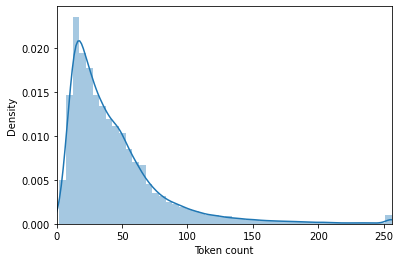

In [11]:
sns.distplot(vocab_length)
plt.xlim([0, 256]);
plt.xlabel('Token count');

most tokens are < 150 so we are going to set 150 as max length (in number of tokens for BERT)

In [16]:
MAX_LEN = 280

### <font color='green'>check the proportion of scores on datasets </font> 

df_train         review_body
score             
0             1920
1             6582
df_val        review_body
score             
0              838
1             1160


<Figure size 432x288 with 0 Axes>

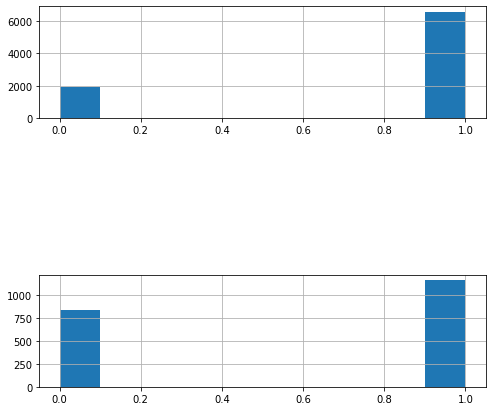

In [143]:
plt.figure()
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(8,7))

plt.subplot(311)
df_train.score.hist()
plt.subplot(313)
df_val.score.hist()

print('df_train ',df_train.groupby('score').count())
print('df_val', df_val.groupby('score').count())

We have all building blocks required to create a PyTorch dataset. Let's do it:

In [ ]:
df_train.review_body.iloc[:4]

0    this medication eases the ringing from tinnitu...
1    i ordered this as it was recommended by my der...
2    if you dont know how to make homemade flavorfu...
3    these tulips were very small and arrived alrea...
Name: review_body, dtype: object

In [141]:
# testing here padding and max length
max_len = 280
for review in  df_train.review_body.iloc[:-1].tolist():
  tokens = tokenizer.tokenize(review) #Tokenize the sentence
  bos_token = tokenizer.cls_token
  eos_token = tokenizer.sep_token
  tokens = [bos_token] + tokens + [eos_token]
  if len(tokens) < max_len:
      tokens = tokens + [tokenizer.pad_token for _ in range(max_len - len(tokens))]

  tokens_ids = tokenizer.convert_tokens_to_ids(tokens) 
  tokens_ids_tensor = torch.tensor(tokens_ids)
  if len(tokens_ids)>max_len:
    print(len(tokens_ids))

In [93]:
class ReviewScoreDataset(Dataset):

  def __init__(self, reviews, targets, tokenizer, max_len):
    self.reviews = reviews
    self.targets = targets
    self.tokenizer = tokenizer
    self.max_len = max_len
  
  def __len__(self):
    return len(self.reviews)
  
  def __getitem__(self, item):
    review = str(self.reviews[item])
    target = self.targets[item]

    tokens = self.tokenizer.tokenize(review) 
    bos_token = self.tokenizer.cls_token
    eos_token = self.tokenizer.sep_token
    tokens = [bos_token] + tokens + [eos_token]
    if len(tokens) < self.max_len:
        tokens = tokens + [self.tokenizer.pad_token for _ in range(self.max_len - len(tokens))]
    else:
        tokens = tokens[:self.max_len-1] + [eos_token] 
    tokens_ids = self.tokenizer.convert_tokens_to_ids(tokens) 
    tokens_ids_tensor = torch.tensor(tokens_ids)
    attn_mask = torch.tensor((tokens_ids_tensor != 0).long())
    return {
      'review_text': review,
      'input_ids': tokens_ids_tensor.flatten(),
      'attention_mask': attn_mask.flatten(),
      'targets': torch.tensor(target, dtype=torch.long)
    }


In [94]:
df_train.shape


(1703, 2)

In [144]:
def create_data_loader(df, tokenizer, max_len, batch_size):
  ds = ReviewScoreDataset(
    reviews=df.review_body.to_numpy(),
    targets=df.score.to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len
  )

  return DataLoader(
    ds,
    batch_size=batch_size,
    num_workers=1
  )

In [145]:
BATCH_SIZE = 32

train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)


In [18]:
train_data_loader

Let's have a look at an example batch from our training data loader:

In [19]:
data = next(iter(train_data_loader))
data['attention_mask'].shape

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


torch.Size([16, 280])

In [20]:
print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['targets'].shape)

torch.Size([16, 280])
torch.Size([16, 280])
torch.Size([16])


## Sentiment Classification with BERT and Hugging Face

In [21]:
bert_model = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
# camembert_model = CamembertModel.from_pretrained("camembert-base")
# camembert_tokenizer = CamembertTokenizer.from_pretrained("camembert-base")


In [ ]:
BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME).config.hidden_size

768

In [22]:
# freeze all the parameters
for param in bert_model.parameters():
    param.requires_grad = False

In [148]:
# class SentimentClassifier(nn.Module):

#   def __init__(self, n_classes):
#     super(SentimentClassifier, self).__init__()
#     self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
#     self.drop = nn.Dropout(p=0.3)
#     self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
  
#   def forward(self, input_ids, attention_mask):
#     pooled_output = self.bert(
#       input_ids=input_ids,
#       attention_mask=attention_mask
#     )
#     output = self.drop(pooled_output[1])
#     return self.out(output)


class SentimentClassifier(nn.Module):

  def __init__(self, n_classes):
    super(SentimentClassifier, self).__init__()
    self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
    self.drop = nn.Dropout(p=0.3)
    self.relu =  nn.ReLU()
    self.dense1 = nn.Linear(768,512) # 768 hidden state of bert
    self.drop2 = nn.Dropout(p=0.1)
    self.dense2 = nn.Linear(512,64)
    self.out = nn.Linear(64,2) # nclass = 2
    self.softmax = nn.LogSoftmax(dim=1)
  
  def forward(self, input_ids, attention_mask):
    pooled_output = self.bert(
      input_ids=input_ids,
      attention_mask=attention_mask
    )
    x = self.dense1(pooled_output[1])
    x = self.relu(x)
    x = self.drop(x)
    x = self.dense2(x)
    x = self.relu(x)
    x = self.drop2(x)
    x = self.out(x)
    x = self.softmax(x)
    return x

In [149]:
model = SentimentClassifier(len(class_names))
model = model.to(device)

We'll move the example batch of our training data to the GPU:

In [25]:
input_ids = data['input_ids'].to(device)
attention_mask = data['attention_mask'].to(device)

print(input_ids.shape) # batch size x seq length
print(attention_mask.shape) # batch size x seq length

torch.Size([16, 280])
torch.Size([16, 280])


### Training

In [150]:

EPOCHS = 10
# optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=True)
total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss().to(device)


class train_model():

  def __init__(self, model, train_data_loader,len_train_data, val_data_loader,len_val_data ,loss_fn, optimizer, device, scheduler, n_epochs=10):
    self.model = model
    self.train_data_loader = train_data_loader
    self.len_train_data = len_train_data
    self.val_data_loader = val_data_loader
    self.len_val_data = len_val_data
    self.loss_fn = loss_fn
    self.optimizer = optimizer
    self.device = device
    self.scheduler = scheduler
    self.epochs = n_epochs


  def train_epoch(self):
    model = self.model.train()

    losses = []
    correct_predictions = 0
    
    for d in self.train_data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)
      model.zero_grad() 
      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)
      loss = self.loss_fn(outputs, targets)

      correct_predictions += torch.sum(preds == targets)
      losses.append(loss.item())

      loss.backward()
      nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
      self.optimizer.step()
      self.scheduler.step()
      self.optimizer.zero_grad()

    return correct_predictions.double() / self.len_train_data, np.mean(losses)


  @torch.no_grad()
  def eval_model(self):
    model = self.model.eval()

    losses = []
    correct_predictions = 0


    for d in self.val_data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)

      loss = self.loss_fn(outputs, targets)

      correct_predictions += torch.sum(preds == targets)
      losses.append(loss.item())

    return correct_predictions.double() / self.len_val_data, np.mean(losses)

  
  def run(self):
    _best_accuracy = 0
    for epoch in range(self.epochs):
      print(f'Epoch {epoch + 1}/{self.epochs}')
      print('↓→←↓'*20)
      train_acc, train_loss = self.train_epoch()
      print(f'Train loss {train_loss} accuracy {train_acc}')
      val_acc, val_loss = self.eval_model()
      print(f'Val   loss {val_loss} accuracy {val_acc}')

      if val_acc > _best_accuracy:
        torch.save(model.state_dict(), 'score_model.bin')
        _best_accuracy = val_acc

In [151]:
%%time
torch.cuda.empty_cache()
sentiment_object = train_model(model, train_data_loader, len(df_train), val_data_loader, len(df_val), loss_fn, optimizer, device, scheduler, EPOCHS)
sentiment_object.run()


Epoch 1/10
↓→←↓↓→←↓↓→←↓↓→←↓↓→←↓↓→←↓↓→←↓↓→←↓↓→←↓↓→←↓↓→←↓↓→←↓↓→←↓↓→←↓↓→←↓↓→←↓↓→←↓↓→←↓↓→←↓↓→←↓


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train loss 0.3449190892559245 accuracy 0.863914373088685


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Val   loss 0.3085277529935988 accuracy 0.8893893893893894
Epoch 2/10
↓→←↓↓→←↓↓→←↓↓→←↓↓→←↓↓→←↓↓→←↓↓→←↓↓→←↓↓→←↓↓→←↓↓→←↓↓→←↓↓→←↓↓→←↓↓→←↓↓→←↓↓→←↓↓→←↓↓→←↓


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train loss 0.17218534166301439 accuracy 0.9429545989179017


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Val   loss 0.3044686730478018 accuracy 0.9224224224224224
Epoch 3/10
↓→←↓↓→←↓↓→←↓↓→←↓↓→←↓↓→←↓↓→←↓↓→←↓↓→←↓↓→←↓↓→←↓↓→←↓↓→←↓↓→←↓↓→←↓↓→←↓↓→←↓↓→←↓↓→←↓↓→←↓


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train loss 0.12347157541802503 accuracy 0.964126087979299


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Val   loss 0.2564290538430214 accuracy 0.9409409409409409
Epoch 4/10
↓→←↓↓→←↓↓→←↓↓→←↓↓→←↓↓→←↓↓→←↓↓→←↓↓→←↓↓→←↓↓→←↓↓→←↓↓→←↓↓→←↓↓→←↓↓→←↓↓→←↓↓→←↓↓→←↓↓→←↓


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train loss 0.08644584260523823 accuracy 0.9787108915549283


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Val   loss 0.23752507066265457 accuracy 0.938938938938939
Epoch 5/10
↓→←↓↓→←↓↓→←↓↓→←↓↓→←↓↓→←↓↓→←↓↓→←↓↓→←↓↓→←↓↓→←↓↓→←↓↓→←↓↓→←↓↓→←↓↓→←↓↓→←↓↓→←↓↓→←↓↓→←↓


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train loss 0.05841351413917273 accuracy 0.9875323453305105


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Val   loss 0.23498945114838463 accuracy 0.94994994994995
Epoch 6/10
↓→←↓↓→←↓↓→←↓↓→←↓↓→←↓↓→←↓↓→←↓↓→←↓↓→←↓↓→←↓↓→←↓↓→←↓↓→←↓↓→←↓↓→←↓↓→←↓↓→←↓↓→←↓↓→←↓↓→←↓


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train loss 0.03777396491434621 accuracy 0.9924723594448365


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Val   loss 0.23339136539115793 accuracy 0.9524524524524525
Epoch 7/10
↓→←↓↓→←↓↓→←↓↓→←↓↓→←↓↓→←↓↓→←↓↓→←↓↓→←↓↓→←↓↓→←↓↓→←↓↓→←↓↓→←↓↓→←↓↓→←↓↓→←↓↓→←↓↓→←↓↓→←↓


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train loss 0.02949577419059281 accuracy 0.9943542695836274


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Val   loss 0.2417181819596047 accuracy 0.9524524524524525
Epoch 8/10
↓→←↓↓→←↓↓→←↓↓→←↓↓→←↓↓→←↓↓→←↓↓→←↓↓→←↓↓→←↓↓→←↓↓→←↓↓→←↓↓→←↓↓→←↓↓→←↓↓→←↓↓→←↓↓→←↓↓→←↓


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train loss 0.020314153626077996 accuracy 0.995883321571395


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Val   loss 0.25528892688637983 accuracy 0.9514514514514515
Epoch 9/10
↓→←↓↓→←↓↓→←↓↓→←↓↓→←↓↓→←↓↓→←↓↓→←↓↓→←↓↓→←↓↓→←↓↓→←↓↓→←↓↓→←↓↓→←↓↓→←↓↓→←↓↓→←↓↓→←↓↓→←↓


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train loss 0.01596757700873357 accuracy 0.9971771347918137


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Val   loss 0.23934164863368051 accuracy 0.9579579579579579
Epoch 10/10
↓→←↓↓→←↓↓→←↓↓→←↓↓→←↓↓→←↓↓→←↓↓→←↓↓→←↓↓→←↓↓→←↓↓→←↓↓→←↓↓→←↓↓→←↓↓→←↓↓→←↓↓→←↓↓→←↓↓→←↓


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train loss 0.014885066481503216 accuracy 0.997529992942837


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Val   loss 0.23931317361411714 accuracy 0.9579579579579579
CPU times: user 44min 50s, sys: 34min 54s, total: 1h 19min 44s
Wall time: 1h 20min 1s


BERT recommendations for fine-tuning:

- Batch size: 16, 32
- Learning rate (Adam): 5e-5, 3e-5, 2e-5
- Number of epochs: 2, 3, 4



# Load Model (saved weights)

In [152]:

#load weights of best model
path = 'score_model.bin'
model.load_state_dict(torch.load(path))

<All keys matched successfully>

## Evaluation

calculating the accuracy on the test data:

In [153]:
take = pd.read_csv('takealot_final_ml_processed.csv')


In [157]:
dt = DataStructure(take[:10000], 0.15, tokenizer)
#X_train, y_train, X_val, y_val = ds.generate_data()
df_train_t, df_val_t, nb = dt.generate_data()

In [158]:
BATCH_SIZE = 16

train_data_loader_t = create_data_loader(df_train_t, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader_t = create_data_loader(df_val_t, tokenizer, MAX_LEN, BATCH_SIZE)

In [51]:
data = next(iter(train_data_loader_t))
len(data['review_text'])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


16

In [52]:
df_val_t =df_val_t.sample(frac=1).reset_index(drop=True)
val_data_loader_t = create_data_loader(df_val_t, tokenizer, MAX_LEN, BATCH_SIZE)
data = next(iter(val_data_loader_t))
data

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


{'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         ...,
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0]]),
 'input_ids': tensor([[  101,  3835,  2452,  ...,     0,     0,     0],
         [  101,  2307,  3643,  ...,     0,     0,     0],
         [  101,  6581,  3601,  ...,     0,     0,     0],
         ...,
         [  101,  2200,  3835,  ...,     0,     0,     0],
         [  101,  2196, 11082,  ...,     0,     0,     0],
         [  101,  1045,  2066,  ...,     0,     0,     0]]),
 'review_text': ['nice cup of coffee  will buy again',
  'great value for money',
  'excellent choice of coffees  something for everyone  good value for money',
  'love this',
  'had the pleasure of making myself a cup and i was extremely satisfied with it it had a beautiful golden layer of crema and it had a wonderful dark chocolate taste with the right amount of bitter

,review,score
0,love this coffeeits mild in flavour but delici...,1
1,tasty but extremely strong,0
2,great stuff exactly what i expected,1
3,yummy pods turns ordinary coffee into somethin...,1
4,really enjoyable,1
...,...,...
587,does not seal properly to maintain correct wat...,0
588,best coffee in a pod on the market,1
589,have ordered this product many times and each ...,1
590,amazing coffee,1


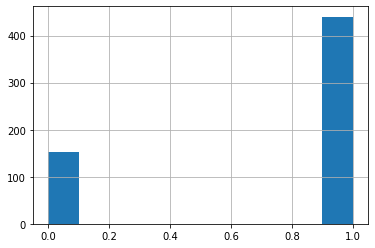

In [ ]:
df_val_t = df_val_t.sample(frac=1).reset_index(drop=True)
df_val_t.score.hist()
df_val_t

In [159]:
def eval_model(model, data_loader, loss_fn, device, n_samples):
  model = model.eval()

  losses = []
  correct_predictions = 0
  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)
      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)
      loss = loss_fn(outputs, targets)

      correct_predictions += torch.sum(preds == targets)
      losses.append(loss.item())

  return correct_predictions.double() / n_samples, np.mean(losses)

test_acc, _ = eval_model(
  model,
  train_data_loader_t,
  loss_fn,
  device,
  len(df_train_t)
)
print(f'Accuracy: {round(test_acc.item(),5)} %')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Accuracy: 0.95312 %


In [160]:

@torch.no_grad()
def get_predictions(model, data_loader):
  model = model.eval()
  
  review_texts = []
  predictions = []
  prediction_probs = []
  real_values = []

  #with torch.no_grad():
  for d in data_loader:

    texts = d["review_text"]
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    targets = d["targets"].to(device)

    outputs = model(
      input_ids=input_ids,
      attention_mask=attention_mask
    )
    _, preds = torch.max(outputs, dim=1)

    probs = F.softmax(outputs, dim=1)

    review_texts.extend(texts)
    predictions.extend(preds)
    prediction_probs.extend(probs)
    real_values.extend(targets)

  predictions = torch.stack(predictions).cpu()
  prediction_probs = torch.stack(prediction_probs).cpu()
  real_values = torch.stack(real_values).cpu()
  return review_texts, predictions, prediction_probs, real_values

In [161]:
y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(
  model,
  train_data_loader_t
)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



classification report

In [162]:
print(classification_report(y_test, y_pred, target_names=class_names))

              precision    recall  f1-score   support

    negative       0.81      0.75      0.78       311
    positive       0.97      0.98      0.97      2505

    accuracy                           0.95      2816
   macro avg       0.89      0.87      0.88      2816
weighted avg       0.95      0.95      0.95      2816



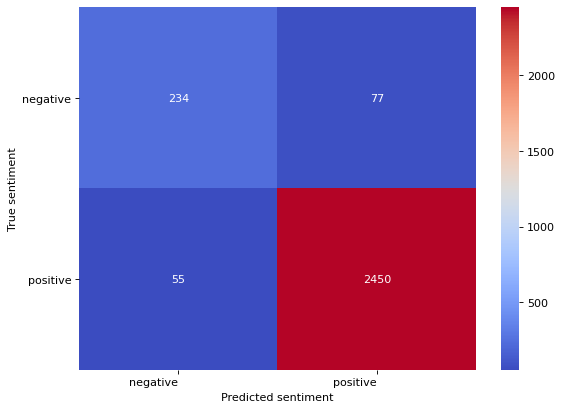

In [163]:
from matplotlib.pyplot import figure
figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="coolwarm")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), ha='right')
  plt.ylabel('True sentiment')
  plt.xlabel('Predicted sentiment');


cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)

### Live Prediction

Let's use our model to predict the sentiment of single review:

In [ ]:
!pip freeze

In [62]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [64]:

model.load_state_dict(torch.load('/content/drive/MyDrive/best_model_state.bin'))
model = model.to(device)

We have to use the tokenizer to encode the text:

In [164]:
def live_prediction(tokenizer, sentence,max_len=MAX_LEN):
  encoded_review = tokenizer.encode_plus(
    sentence,
    max_length=MAX_LEN,
    add_special_tokens=True,
    return_token_type_ids=False,
    padding=True,
    return_attention_mask=True,
    return_tensors='pt',
  )

  class_names =['Negative', 'Positive']
  input_ids = encoded_review['input_ids'].to(device)
  attention_mask = encoded_review['attention_mask'].to(device)

  output = model(input_ids, attention_mask)
  # print(output)
  _, prediction = torch.max(output, dim=1)
  print(_, prediction)
  results = {}
  results['Review_text']= sentence
  results['Sentiment']= class_names[prediction]
  return results


In [165]:
review_text = 'not the result i wanted'
live_prediction(tokenizer, review_text)


tensor([-0.0024], device='cuda:0', grad_fn=<MaxBackward0>) tensor([0], device='cuda:0')


{'Review_text': 'not the result i wanted', 'Sentiment': 'Negative'}

In [166]:

reviews= ['it tastes like ass','i wont buy this anymore its watery','absolutely love the taste amazing', "got shipped in 2 days, nice", 'fake coffe i would give it a 0 star hate it', "too expensive but still good taste"]
for review in reviews:
  result = live_prediction(tokenizer, review)
  print('↓→←↓'*20)
  score_color = "green" if 'Positive' in result['Sentiment'] else "red"
  print ('the Review: ', colored(result['Review_text'],"yellow") ,' the predicted sentiment is: ' ,colored(result['Sentiment'], score_color), '\n')

tensor([-0.0012], device='cuda:0', grad_fn=<MaxBackward0>) tensor([1], device='cuda:0')
↓→←↓↓→←↓↓→←↓↓→←↓↓→←↓↓→←↓↓→←↓↓→←↓↓→←↓↓→←↓↓→←↓↓→←↓↓→←↓↓→←↓↓→←↓↓→←↓↓→←↓↓→←↓↓→←↓↓→←↓
the Review:  it tastes like ass  the predicted sentiment is:  Positive 

tensor([-0.0025], device='cuda:0', grad_fn=<MaxBackward0>) tensor([0], device='cuda:0')
↓→←↓↓→←↓↓→←↓↓→←↓↓→←↓↓→←↓↓→←↓↓→←↓↓→←↓↓→←↓↓→←↓↓→←↓↓→←↓↓→←↓↓→←↓↓→←↓↓→←↓↓→←↓↓→←↓↓→←↓
the Review:  i wont buy this anymore its watery  the predicted sentiment is:  Negative 

tensor([-0.0008], device='cuda:0', grad_fn=<MaxBackward0>) tensor([1], device='cuda:0')
↓→←↓↓→←↓↓→←↓↓→←↓↓→←↓↓→←↓↓→←↓↓→←↓↓→←↓↓→←↓↓→←↓↓→←↓↓→←↓↓→←↓↓→←↓↓→←↓↓→←↓↓→←↓↓→←↓↓→←↓
the Review:  absolutely love the taste amazing  the predicted sentiment is:  Positive 

tensor([-0.0008], device='cuda:0', grad_fn=<MaxBackward0>) tensor([1], device='cuda:0')
↓→←↓↓→←↓↓→←↓↓→←↓↓→←↓↓→←↓↓→←↓↓→←↓↓→←↓↓→←↓↓→←↓↓→←↓↓→←↓↓→←↓↓→←↓↓→←↓↓→←↓↓→←↓↓→←↓↓→←↓
the Review:  got shipped in 2 days, nice  the predicted sentiment is:  Pos

### <font color='green'> méthod 2: using pre trained finetuned bert multilingual for sentiment analysis</font> 

Mounted at /content/drive


In [ ]:

from adaptnlp import EasySequenceClassifier
from pprint import pprint
df = pd.read_csv('takealot_final_ml_processed.csv')

def to_sentiment(rating):
  rating = int(rating)
  if rating < 3:
    return 0
  else:
    return 1

df['sentiment'] = df.review_rating.apply(to_sentiment)

# https://novetta.github.io/adaptnlp/tutorial/sequence-classification.html
classifier = EasySequenceClassifier()
# Inference
example_text = "j achète ce produit assez régulièrement  pour son bon rapport qualité prix produit frais et assez gouteux bon rapport qualité"

sentences = classifier.tag_text(
    text=example_text,
    model_name_or_path="nlptown/bert-base-multilingual-uncased-sentiment",
    mini_batch_size=1,
)

print("Tag Score Outputs:\n")
for sentence in sentences:
    pprint({sentence.to_original_text(): sentence.labels})

labels_list = [item.to_dict() for item in sentences[0].labels]
new_dict = {
    item['value'].split(' ')[0]:item['confidence'] for item in  labels_list}
predicted_rating = max(new_dict, key=new_dict.get)
predicted_score = 1 if int(predicted_rating) > 3 else 0
print(predicted_rating, predicted_score)

2020-12-27 00:58:29,465 loading file nlptown/bert-base-multilingual-uncased-sentiment


/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:2022: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
Predicting text: 100%|██████████| 1/1 [00:00<00:00, 57.07it/s]

Tag Score Outputs:

{'j achète ce produit assez régulièrement  pour son bon rapport qualité prix produit frais et assez gouteux bon rapport qualité': [1 star (0.0094),
                                                                                                                                   2 stars (0.0384),
                                                                                                                                   3 stars (0.3891),
                                                                                                                                   4 stars (0.3882),
                                                                                                                                   5 stars (0.1749)]}
3 0


In [ ]:
#max(sentence.labels.to_dict(), key=sentence.labels.to_dict().get)
sentence.labels[2].to_dict()

{'confidence': 0.10610610246658325, 'value': '3 stars'}

'1'

In [ ]:
# cleaning data
from pandas import DataFrame
from string import punctuation
from adaptnlp import EasySequenceClassifier


logging.getLogger('allennlp.common.params').disabled = True 
logging.getLogger('allennlp.nn.initializers').disabled = True 
logging.getLogger('allennlp.modules.token_embedders.embedding').setLevel(logging.INFO) 


class NlptownPrediction():

  def __init__(self, dataframe):
    self.df = dataframe


  # generator to apply functions on dataframe
  def filter_df(self):
    def apply_on_df(*a, **kw):
        def apply(func):
            df = kw['df']
            column = kw['column']
            df[column] = df[column].apply(lambda x: func(x))
        return apply

    @apply_on_df(df=self.df, column='review')
    def remove_punctuation(x):
        for char in punctuation:
            x = str(x).replace(char, '')
        return x

    classifier = EasySequenceClassifier()
    
  @staticmethod
  def predict_sentiment_rating(sentence):
    sentences = classifier.tag_text(
        text=sentence,
        model_name_or_path="nlptown/bert-base-multilingual-uncased-sentiment",
        mini_batch_size=1,
    )
    labels_list = [item.to_dict() for item in sentences[0].labels]
    new_dict = {
        item['value'].split(' ')[0]:item['confidence'] for item in  labels_list}
    predicted_rating = max(new_dict, key=new_dict.get)
    predicted_score = 1 if int(predicted_rating) > 3 else 0
    return predicted_rating, predicted_score

  def generate_data(self):
      # self.filter_df()
      
      # setting positifs 1 for rating >3
      df['score'] = df['review_rating'].apply(lambda x: 1 if x > 3 else 0)
      df['predicted_score'] = df['review'].apply(lambda x: self.predict_sentiment_rating(x)[1])
      df['predicted_rating'] = df['review'].apply(lambda x: self.predict_sentiment_rating(x)[0])
      return df





In [ ]:
df = pd.read_csv('takealot_final_ml_processed.csv')
df = morrisons
nlptown_class = NlptownPrediction(df)

In [ ]:
%%capture
result = nlptown_class.generate_data()

In [ ]:
result[ 'predicted_rating'] =  result.predicted_rating.apply(pd.to_numeric) 


In [ ]:
print(classification_report(result['review_rating'], result['predicted_rating'], target_names=['1','2','3','4','5']))

              precision    recall  f1-score   support

           1       0.85      0.66      0.74      5707
           2       0.25      0.49      0.33      1650
           3       0.30      0.55      0.39      1664
           4       0.32      0.45      0.37      3418
           5       0.92      0.74      0.82     15698

    accuracy                           0.66     28137
   macro avg       0.53      0.58      0.53     28137
weighted avg       0.75      0.66      0.69     28137



In [ ]:
print(classification_report(result['score'], result['predicted_score'], target_names=[ 'negatif', 'positif']))

              precision    recall  f1-score   support

     negatif       0.80      0.96      0.87      9021
     positif       0.98      0.89      0.93     19116

    accuracy                           0.91     28137
   macro avg       0.89      0.92      0.90     28137
weighted avg       0.92      0.91      0.91     28137



In [ ]:
result.review.loc[result.review_rating < 3].iloc[32]

'coffee is great  '

In [ ]:
result[['review_rating', 'predicted_rating']].sample(10)

,review_rating,predicted_rating
531,5,5
2086,5,5
2162,4,4
1650,5,5
2651,5,4
1343,3,3
127,4,5
2027,5,5
2004,5,5
63,4,5


In [ ]:
result[['review','score', 'predicted_score','review_rating']].sample(10)

,review,score,predicted_score,review_rating
2393,just sublime if you like a full flavoured rich...,1,1,5
2864,better than the other nondairy milks,1,1,4
1863,a lovely decaffeinated coffee enjoy the rich a...,1,1,5
2394,pleasant and easily drinkable however its a me...,0,1,3
2589,after many tries for month this one is still m...,1,1,4
2365,good taste but slightly on the weak side the p...,0,0,3
729,this a great tasting coffee which is not too b...,1,1,5
2281,nice and tasty way to wind down from a busy day,1,1,4
2793,not really that spicy all though the taste is ...,0,0,3
2318,i love the bulk pack really good coffee defini...,1,1,5


In [ ]:
result.review.iloc[3273]

'its really good if you like hot stuff without the hot sauce its kind off bland so would not recommend if you have sensitive taste buds '

### Working with French Reviews

In [ ]:
!gsutil cp gs://di_data_sas/FR/Coursesu/Data/2020_periode_10/coursesu_ml_opinions.csv courseu.csv

Copying gs://di_data_sas/FR/Coursesu/Data/2020_periode_10/coursesu_ml_opinions.csv...
- [1 files][ 17.7 MiB/ 17.7 MiB]                                                
Operation completed over 1 objects/17.7 MiB.                                     


In [ ]:
df = pd.read_csv('courseu.csv')
df = df[:2000]
nlptown_class = NlptownPrediction(df)

In [ ]:
%%capture
result = nlptown_class.generate_data()

In [ ]:
result[ 'predicted_rating'] =  result.predicted_rating.apply(pd.to_numeric) 


In [ ]:
print(classification_report(result['review_rating'], result['predicted_rating'], target_names=['1','2','3','4','5']))

              precision    recall  f1-score   support

           1       0.36      0.55      0.43        44
           2       0.25      0.69      0.37        39
           3       0.30      0.44      0.36       135
           4       0.44      0.43      0.44       529
           5       0.81      0.72      0.76      1253

    accuracy                           0.62      2000
   macro avg       0.43      0.57      0.47      2000
weighted avg       0.66      0.62      0.63      2000



In [ ]:
print(classification_report(result['score'], result['predicted_score'], target_names=[ 'negatif', 'positif']))

              precision    recall  f1-score   support

     negatif       0.52      0.89      0.66       218
     positif       0.98      0.90      0.94      1782

    accuracy                           0.90      2000
   macro avg       0.75      0.89      0.80      2000
weighted avg       0.93      0.90      0.91      2000



In [ ]:
result[['review','score', 'predicted_score','review_rating']].sample(10)

,review,score,predicted_score,review_rating
1517,bonne feta.\r\nutilisée avec une salade de tom...,1,1,5
107,acheté en drive et consommé à la maison ! déli...,1,1,5
1059,je n’achète plus que cette référence : pas tro...,1,1,5
407,j achète cette eau pour mettre dans ma machine...,0,0,3
851,j'achète ce produit régulièrement et en suis t...,1,1,5
494,j'achète régulièrement ce produit . nous préfé...,1,0,5
1428,"bon jus de pomme, produit frais je recommande ...",1,1,4
1184,j'ai acheté ce shampoing sec car il était abor...,0,0,1
1810,beaucoup trop salé !!! il y a du avoir un prob...,0,0,1
1298,"excellent produit, très goûteux , se conserve ...",1,1,5


In [ ]:
result['diff'] = result['score'] - result['predicted_score'] 

In [ ]:
result.groupby('diff')['diff'].count()/result.shape[0]

diff
-1    0.0125
 0    0.9000
 1    0.0875
Name: diff, dtype: float64

In [ ]:
from torchvision import models
model = models.vgg16()
print(model)

In [ ]:
result[['review','review_rating']].iloc[30944]

#### Using transformers pipeline  to make sentiment analysis

In [ ]:
from transformers import pipeline, AutoModelForTokenClassification, AutoTokenizer

# Sentiment analysis pipeline
pipeline('sentiment-analysis')
SA = pipeline('sentiment-analysis', 'nlptown/bert-base-multilingual-uncased-sentiment')

In [141]:
polarity = {'1': 'Positive', '0': 'Negative'}
entry = input()
def live_pred_using_torchpipeline(sentence):
  res = SA(entry)[0]
  label = res['label'].split(' ')[0]
  predicted_score = 1 if int(label) > 3 else 0
  return label, polarity[str(predicted_score)]

live_pred_using_torchpipeline(sentence1)

i like the taste and the price


('4', 'Positive')

In [ ]:
res = SA(sentence1)[0]
res['score']